# Experimental CNN Framework for Landsat Classification

In [1]:
import rasterio
import numpy as np
from rasterio.plot import adjust_band
import matplotlib.pyplot as plt
from rasterio.plot import reshape_as_raster, reshape_as_image
from rasterio.plot import show
from rasterio.windows import Window
from pyproj import Proj, transform
import random
import math
import itertools

from classifier_utilities import *

### importing datasets

In [2]:
label_dataset = rasterio.open('/deep_data/landcover_reproject.tif')
label_image = label_dataset.read()

"""
l8_image_paths = ['/deep_data/processed_landsat/LC08_CU_027012_20170907_20181121_C01_V01_SR_combined.tif',
               '/deep_data/processed_landsat/LC08_CU_028012_20140814_20171017_C01_V01_SR_combined.tif',
               '/deep_data/processed_landsat/LC08_CU_028011_20170907_20181130_C01_V01_SR_combined.tif',  
               '/deep_data/processed_landsat/LC08_CU_028012_20171002_20171019_C01_V01_SR_combined.tif']
"""

l8_image_paths = ['/deep_data/processed_landsat/LC08_CU_028012_20171002_20171019_C01_V01_SR_combined.tif']

s1_image_paths = ['/deep_data/sentinel_sar/LC08_CU_028012_20171002_20171019_C01_V01_SR_combined/LC08_CU_028012_20171002_20171019_C01_V01_SR_combined_SAR.tif']

landsat_datasets = []
for fp in l8_image_paths:
    landsat_datasets.append(rasterio.open(fp))
    
sentinel_datasets = []
for fp in s1_image_paths:
    sentinel_datasets.append(rasterio.open(fp))



In [3]:
# What is the raster's projection?
image_proj = landsat_datasets[0].crs # 4326
print('Image projection:')
print(image_proj)
print('---')
# What is the raster's projection?
label_proj = sentinel_datasets[0].crs
print('Labels projection:')
print(label_proj)
print('---')
# What is the raster's projection?
label_proj = label_dataset.crs
print('Labels projection:')
print(label_proj)

Image projection:
PROJCS["Albers",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378140,298.2569999999957,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]
---
Labels projection:
EPSG:4326
---
Labels projection:
EPSG:32618


### Class Dictionary and Confusion Matrix Function

In [4]:
class_names = dict((
(0,  'Background'),
(1, 'Unclassified'),
(2, 'High Intensity Developed'),
(3, 'Medium Intensity Developed'),
(4, 'Low Intensity Developed'),
(5, 'Open Space Developed'),
(6, 'Cultivated Land'),
(7, 'Pasture/Hay'),
(8, 'Grassland'),
(9, 'Deciduous Forest'),
(10, 'Evergreen Forest'),
(11, 'Mixed Forest'),
(12, 'Scrub/Shrub'),
(13, 'Palustrine Forested Wetland'),
(14, 'Palustrine Scrub/Shrub Wetland'),
(15, 'Palustrine Emergent Wetland'),
(16, 'Estuarine Forested Wetland'),
(17, 'Estuarine Scrub/Shrub Wetland'),
(18, 'Estuarine Emergent Wetland'),
(19, 'Unconsolidated Shore'),
(20, 'Bare Land'),
(21, 'Water'),
(22, 'Palustrine Aquatic Bed'),
(23, 'Estuarine Aquatic Bed'),
(24, 'Tundra'),
(25, 'Snow/Ice')
))

## Test out the generator and data prep functions

Let's make sure all this data prep actually works.

In [5]:
# generate the training and validation pixel locations
train_px, val_px = gen_pixel_locations(landsat_datasets, 20, 20, 64)

In [6]:
# print out some image and label batches and check out their shapes
im_batch = None

count = 0
for (im, label) in tile_generator(landsat_datasets, sentinel_datasets, label_dataset, 64, 64, train_px, 10):
    if count > 3:
        break
    print('Image')
    print(im.shape)
    print('Label')
    print(label)
    print(label.shape)
    print('----')
    count += 1
    im_batch = im

Image
(10, 64, 64, 9)
Label
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]]
(10, 26)
----
Image
(10, 64, 64, 9)
Label
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0.

### Visually inspect an image patch

While it shouldn't necessarily be recognizable it should look like it has data in it and that it varies somewhat from pixel to pixel.

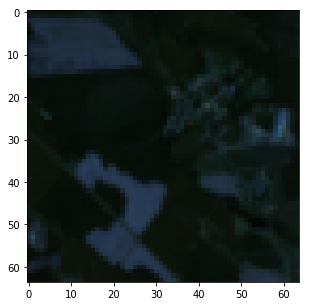

In [7]:
fig, axs = plt.subplots(1, 1, figsize=(18, 5)) 

axs.imshow(im_batch[0,:,:,1:4])

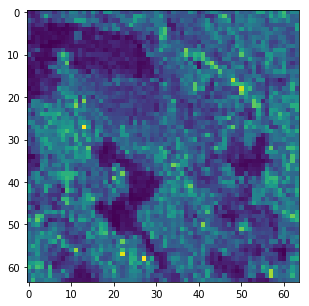

In [8]:
fig, axs = plt.subplots(1, 1, figsize=(18, 5)) 
axs.imshow(im_batch[0,:,:,8])

## Let's get to the CNN Development!!

In [9]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
# The GPU id to use
# Patrick "0"
# Feroze  "1"
# Yousuf  "2"
# Diego   "3"
os.environ["CUDA_VISIBLE_DEVICES"]="0";

In [10]:
# Do other imports now...
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

### prep some of the hyperparameters

In [11]:
batch_size = 25
label_image[label_image == 255] = 1
num_classes = len(class_names)
epochs = 50

# input image dimensions
tile_side = 64
img_rows, img_cols = tile_side, tile_side
img_bands = landsat_datasets[0].count + sentinel_datasets[0].count - 1

input_shape = (img_rows, img_cols, img_bands)
print(input_shape)

(64, 64, 9)


### build the model

This is just a simple CNN model but it should be able to perform well above random when predicting landcover types if everything is correct thus far.

In [12]:
model = Sequential()

model.add(Conv2D(tile_side, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(22, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 64)        5248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 22)        12694     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 22)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 30, 22)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 30, 30, 64)        12736     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
__________

#### Future Models for Experimentation

In [82]:
from keras.models import Model
mod = Model([inputs=[inputs], outputs=[conv2]])
mod.predict(inp_data)

SyntaxError: invalid syntax (<ipython-input-82-da7b2d6e9450>, line 2)

In [94]:
from keras import regularizers

model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
 
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
 
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
 
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))
 
model.summary()

NameError: name 'regularizers' is not defined

#### Generate the train/validation pixel locations to train with

In [13]:
train_px, val_px = gen_pixel_locations(image_datasets=landsat_datasets, 
                                       train_count=2000, val_count=500, tile_size=tile_side)

#### set up the remaining model hyperparameters and compile

In [14]:
sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
metrics=['accuracy']

model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=metrics)

#### TRAIN THE MODEL!

In [16]:
model.fit_generator(generator=tile_generator(landsat_datasets, sentinel_datasets, label_dataset, tile_side, tile_side, train_px, batch_size), 
                    steps_per_epoch=len(train_px) // batch_size, epochs=epochs, verbose=1,
                    validation_data=tile_generator(landsat_datasets, sentinel_datasets, label_dataset, tile_side, tile_side, val_px, batch_size),
                    validation_steps=len(val_px) // batch_size)

Epoch 1/50
80/80 [==============================] - 8s 97ms/step - loss: 2.2292 - acc: 0.2310 - val_loss: 2.0691 - val_acc: 0.1520
Epoch 2/50
80/80 [==============================] - 5s 62ms/step - loss: 2.0588 - acc: 0.2390 - val_loss: 2.0520 - val_acc: 0.2760
Epoch 3/50
80/80 [==============================] - 5s 63ms/step - loss: 2.0309 - acc: 0.2450 - val_loss: 2.0185 - val_acc: 0.2880
Epoch 4/50
80/80 [==============================] - 5s 58ms/step - loss: 2.0356 - acc: 0.2410 - val_loss: 2.0229 - val_acc: 0.2760
Epoch 5/50
80/80 [==============================] - 5s 57ms/step - loss: 2.0111 - acc: 0.2415 - val_loss: 2.0324 - val_acc: 0.2760
Epoch 6/50
80/80 [==============================] - 5s 56ms/step - loss: 2.0153 - acc: 0.2505 - val_loss: 2.0150 - val_acc: 0.2740
Epoch 7/50
80/80 [==============================] - 4s 55ms/step - loss: 1.9915 - acc: 0.2605 - val_loss: 2.0113 - val_acc: 0.3060
Epoch 8/50
13/80 [===>..........................] - ETA: 2s - loss: 2.0115 - acc: 0

KeyboardInterrupt: 

### Now let's evaluate the Model

We'll just generate 500 test pixels to evaluate it on

Keras has a built in evaluate_generator function and because we told it above to use accuracy as a metric this function automatically outputs categorical accuracy which is what we want.

In [17]:
train_px, val_px = gen_pixel_locations(image_datasets=landsat_datasets, 
                                       train_count=0, val_count=1000, tile_size=tile_side)

In [19]:
model.evaluate_generator(generator=tile_generator(landsat_datasets, sentinel_datasets, label_dataset, tile_side, tile_side, val_px, batch_size), 
                        steps=len(val_px) // batch_size,
                         verbose=1)

40/40 [==============================] - 4s 96ms/step


[1.995003405213356, 0.2669999999925494]

So in this simple model we're getting 37% accuracy across 23 classes which is well above the random accuracy which would be around 4% (aka 1/23). That means we're in business!

### Evaluating the model ourselves

If we wanted to run this evaluation and take a look at specific predictions and labels we can do that below (albeit more inefficiently) just to get an intuitive understanding of what is going wrong.

In [20]:
predictions = model.predict_generator(generator=tile_generator(landsat_datasets, sentinel_datasets, label_dataset, 
                        tile_side, tile_side, val_px, batch_size), 
                        steps=len(val_px) // batch_size,
                         verbose=1)


40/40 [==============================] - 4s 96ms/step


In [21]:
eval_generator = tile_generator(landsat_datasets, sentinel_datasets, label_dataset, tile_side, tile_side, val_px, batch_size=1)

In [22]:
labels = np.empty(predictions.shape)
count = 0
while count < len(val_px):
    image_b, label_b = next(eval_generator)
    labels[count] = label_b
    count += 1

In [23]:
labels.shape

(1000, 26)

In [24]:
label_index = np.argmax(labels, axis=1)     
pred_index = np.argmax(predictions, axis=1)

In [25]:
correct_predictions = np.zeros(pred_index.shape)
correct_predictions[label_index == pred_index] = 1

In [26]:
np.count_nonzero(correct_predictions) / len(val_px)

0.267

Now maybe more informatively let's build a confusion matrix using the scikit-learn function.

Read the docs here and make this more informative by following some of their examples: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

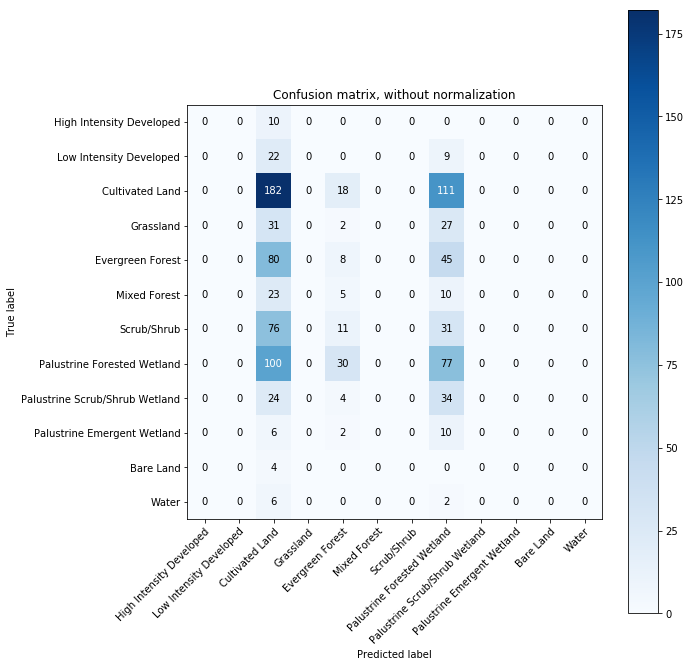

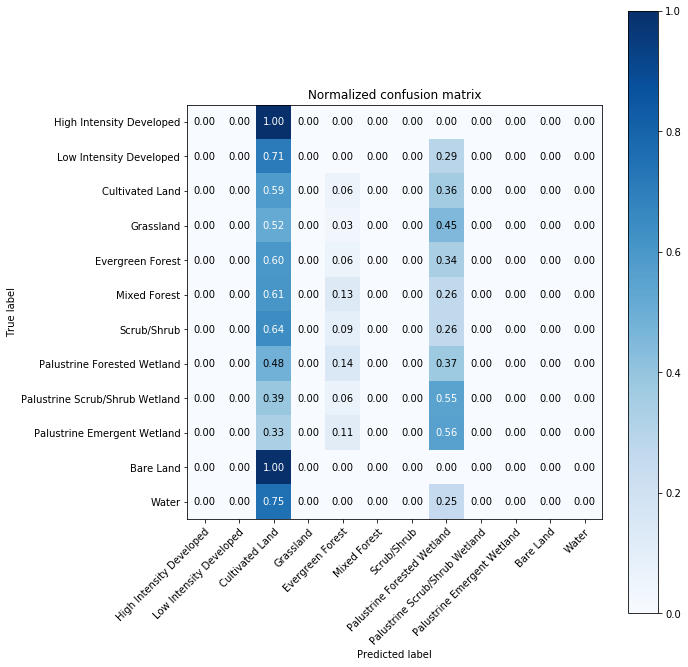

In [27]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names)

# Plot normalized confusion matrix
plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names,
                      normalize=True)

In [28]:
unique, counts = np.unique(label_index, return_counts=True)
dict(zip(unique, counts))

{2: 10,
 4: 31,
 6: 311,
 8: 60,
 10: 133,
 11: 38,
 12: 118,
 13: 207,
 14: 62,
 15: 18,
 20: 4,
 21: 8}